In [1]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os

from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.48027929/ipykernel_14108/889698852.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [2]:
# load in all the metrics files
output_dir = '/home/klawren/oak/gtex/output/caudate_analysis'

def get_metrics(output_dir):
    metrics = []
    for filename in os.listdir(os.path.join(output_dir, 'rnaseq_qc')):
            if filename.endswith('metrics.tsv'):
                metrics.append(pd.read_csv(os.path.join(output_dir, f'rnaseq_qc/{filename}'), sep='\t', index_col=0))
    return pd.concat(metrics, axis=1).T

v11_metrics = get_metrics('/home/klawren/oak/gtex/output/caudate_analysis')
v10_metrics = get_metrics('/home/klawren/oak/gtex/output/caudate_v10')

In [3]:
merged_metrics = pd.merge(v11_metrics.reset_index(), v10_metrics.reset_index(), on='index', suffixes=[' with v47', ' with v39'])

In [4]:
merged_metrics.columns.values

array(['index', 'Mapping Rate with v47', 'Unique Rate of Mapped with v47',
       'Duplicate Rate of Mapped with v47',
       'Duplicate Rate of Mapped, excluding Globins with v47',
       'Base Mismatch with v47', 'End 1 Mapping Rate with v47',
       'End 2 Mapping Rate with v47', 'End 1 Mismatch Rate with v47',
       'End 2 Mismatch Rate with v47',
       'Expression Profiling Efficiency with v47',
       'High Quality Rate with v47', 'Exonic Rate with v47',
       'Intronic Rate with v47', 'Intergenic Rate with v47',
       'Intragenic Rate with v47', 'Ambiguous Alignment Rate with v47',
       'High Quality Exonic Rate with v47',
       'High Quality Intronic Rate with v47',
       'High Quality Intergenic Rate with v47',
       'High Quality Intragenic Rate with v47',
       'High Quality Ambiguous Alignment Rate with v47',
       'Discard Rate with v47', 'rRNA Rate with v47',
       'End 1 Sense Rate with v47', 'End 2 Sense Rate with v47',
       'Avg. Splits per Read with v47'

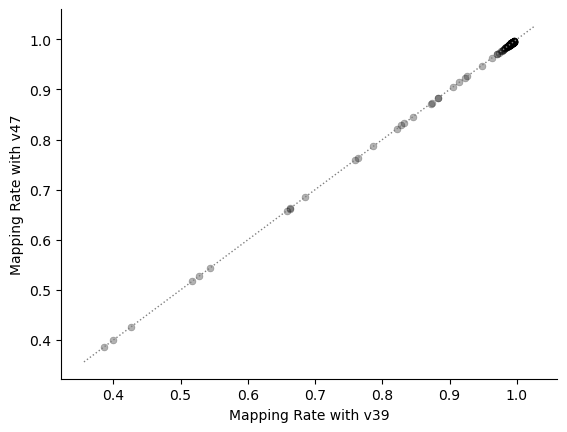

In [5]:
ax = sns.scatterplot(merged_metrics, x='Mapping Rate with v39', y='Mapping Rate with v47', s=25, edgecolor=None, alpha=.3, color='k')
ax.spines[['top', 'right']].set_visible(False)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # lower limit
    np.max([ax.get_xlim(), ax.get_ylim()]),  # upper limit
]

ax.plot(lims, lims, ls=':', color='gray', linewidth=1)


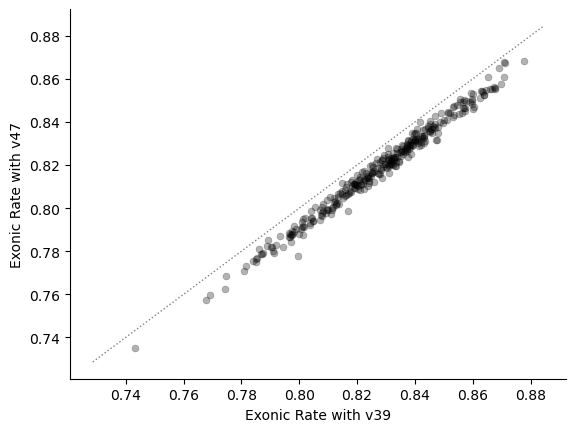

In [6]:
ax = sns.scatterplot(merged_metrics, x='Exonic Rate with v39', y='Exonic Rate with v47', s=25, edgecolor=None, alpha=.3, color='k')
ax.spines[['top', 'right']].set_visible(False)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # lower limit
    np.max([ax.get_xlim(), ax.get_ylim()]),  # upper limit
]

ax.plot(lims, lims, ls=':', color='gray', linewidth=1)


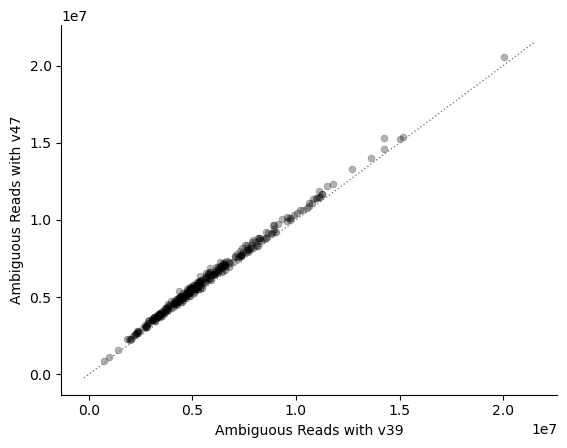

In [7]:
ax = sns.scatterplot(merged_metrics, x='Ambiguous Reads with v39', y='Ambiguous Reads with v47', s=25, edgecolor=None, alpha=.3, color='k')
ax.spines[['top', 'right']].set_visible(False)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # lower limit
    np.max([ax.get_xlim(), ax.get_ylim()]),  # upper limit
]

ax.plot(lims, lims, ls=':', color='gray', linewidth=1)


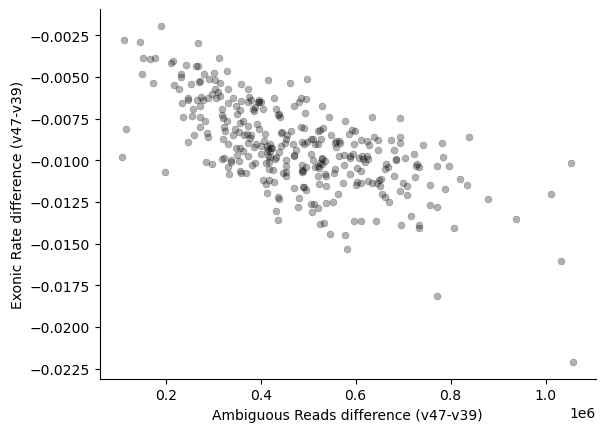

In [8]:
merged_metrics['Ambiguous Reads difference (v47-v39)'] = merged_metrics['Ambiguous Reads with v47']-merged_metrics['Ambiguous Reads with v39']
merged_metrics['Exonic Rate difference (v47-v39)'] = merged_metrics['Exonic Rate with v47']-merged_metrics['Exonic Rate with v39']
ax = sns.scatterplot(merged_metrics, x='Ambiguous Reads difference (v47-v39)', y='Exonic Rate difference (v47-v39)', s=25, edgecolor=None, alpha=.3, color='k')

ax.spines[['top', 'right']].set_visible(False)


### how much in Mb is lost in one vs the other?

In [ ]:
import pybedtools

In [10]:
gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode/gencode.v39.genes.gtf"
gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.genes.gtf"

# load in gencode for lncRNA annotations
gencode_v47=pr.read_gtf(gencode_v47_path).as_df()
gencode_v39=pr.read_gtf(gencode_v39_path).as_df()

In [11]:
# Calculate the number of base pairs in each file
bp_gencode_v39 = gencode_v39[gencode_v39['Feature']=='exon'].apply(lambda row: row['End'] - row['Start'], axis=1).sum()
bp_gencode_v47 = gencode_v47[gencode_v47['Feature']=='exon'].apply(lambda row: row['End'] - row['Start'], axis=1).sum()

print(f"Total base pairs in gencode_v39: {bp_gencode_v39}")
print(f"Total base pairs in gencode_v47: {bp_gencode_v47}")


Total base pairs in gencode_v39: 134022808
Total base pairs in gencode_v47: 159688825


In [12]:
# Convert DataFrames to BedTool objects
gencode_v39_bed = pybedtools.BedTool.from_dataframe(gencode_v39[gencode_v39['Feature']=='exon'][['Chromosome', 'Start', 'End']])
gencode_v47_bed = pybedtools.BedTool.from_dataframe(gencode_v47[gencode_v47['Feature']=='exon'][['Chromosome', 'Start', 'End']])

In [13]:
# Find regions unique to gencode_v47
unique_v47_bed = gencode_v47_bed.subtract(gencode_v39_bed)

# Find regions unique to gencode_v39
unique_v39_bed = gencode_v39_bed.subtract(gencode_v47_bed)

# Calculate the number of base pairs unique to gencode_v47
unique_v47_df = unique_v47_bed.to_dataframe(names=['chr', 'start', 'end'])
bp_unique_v47 = unique_v47_df.apply(lambda row: row['end'] - row['start'], axis=1).sum()

# Calculate the number of base pairs unique to gencode_v39
unique_v39_df = unique_v39_bed.to_dataframe(names=['chr', 'start', 'end'])
bp_unique_v39 = unique_v39_df.apply(lambda row: row['end'] - row['start'], axis=1).sum()

print(f"Total base pairs unique to gencode_v47: {bp_unique_v47}")
print(f"Total base pairs unique to gencode_v39: {bp_unique_v39}")


Total base pairs unique to gencode_v47: 29779891
Total base pairs unique to gencode_v39: 4113874


In [14]:
intersection_bed = gencode_v39_bed.intersect(gencode_v47_bed, wa=True, wb=True)


# Convert intersection to DataFrame
intersection_df = intersection_bed.to_dataframe(names=['chr', 'start', 'end', 'chr2', 'start2', 'end2'])

# Calculate the number of base pairs in the intersection
bp_intersection = intersection_df.apply(lambda row: min(row['end'], row['end2']) - max(row['start'], row['start2']), axis=1).sum()

print(f"Total base pairs in intersection: {bp_intersection}")

Total base pairs in intersection: 129908934


In [ ]:
labels = [f"{value / 1_000_000:.2f}" for value in data]


['29.78', '4.11', '129.91']

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


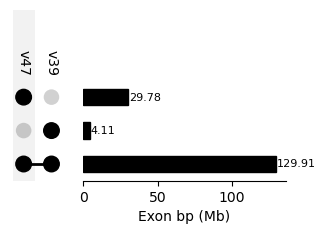

In [28]:
# Create a DataFrame with boolean indices for the sets
data = pd.Series({
    (True, False): bp_unique_v47,
    (False, True): bp_unique_v39,
    (True, True): bp_intersection
})

data.index.names = ['v47', 'v39']
upset = up.UpSet(data, show_counts=False, orientation='vertical', intersection_plot_elements=6, totals_plot_elements=0)

fig = plt.figure(figsize=(5, 5))
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

inter_ax = plot_result['intersections']
inter_ax.grid(False)
inter_ax.set_xlabel('Exon bp (Mb)')
inter_ax.set_xticks([0, .5e8, 1e8], labels=['0', '50', '100'])

labels = [f"{value / 1_000_000:.2f}" for value in data]
labels = ['129.91', '4.11', '29.78',]

for container in inter_ax.containers:
    inter_ax.bar_label(container, padding=1, fontsize=8,labels=labels)